# **1. Introduction and Setup**
In this section, we import the necessary libraries for data manipulation and visualization(Pandas Numpy Matplotlib). We also established a connection to the SQLite database viewer_interactions.db to retrieve the dataset. First of all, we need to check the database schema to get the structures of tables.

---




In [43]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Now we need to connect out database
db_path = 'viewer_interactions.db'
conn = sqlite3.connect(db_path)
# we also need to find what tables are ins
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables found in the database:")
print(tables)

Tables found in the database:
               name
0    viewer_ratings
1            movies
2   user_statistics
3  movie_statistics
4   data_dictionary


# 2. Data Loading and Inspection
We will now load the data from tables to pandas
viewer_ratings: interaction data (user, movie, rating, timestamp)

movies: content metadata (genres, titles) needed to undestand preferences.

user_statistics: user metrics valuable for segmentation.

We will also check the data disct to understand each column.

In [44]:
# Now lets load the files
df_ratings = pd.read_sql("SELECT * FROM viewer_ratings", conn)
df_movies = pd.read_sql("SELECT * FROM movies", conn)
df_users = pd.read_sql("SELECT * FROM user_statistics", conn)
df_dict = pd.read_sql("SELECT * FROM data_dictionary", conn)

print(" Viewer Ratings ")
display(df_ratings.head())
# also need to display the data
print("\n Movies Metadata ")
display(df_movies.head())
print("\n User Statistics ")
display(df_users.head())
print("\n Data Dictionary ")
pd.set_option('display.max_colwidth', None)
display(df_dict)

 Viewer Ratings 


,movie_id,customer_id,rating,date,anomalous_date
0,17,1481737,3.0,2005-10-09,NaN
1,9236,1448424,5.0,2005-11-15,NaN
2,4640,2308980,NaN,2005-08-06,NaN
3,9330,674346,3.0,2005-04-29,NaN
4,4570,1304045,4.0,2005-09-19,NaN



 Movies Metadata 


,movie_id,year_of_release,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW



 User Statistics 


,customer_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_movies,first_rating_date,last_rating_date,activity_days
0,1965326,8.0,3.250000,0.886405,2.0,5.0,8.0,2004-08-11,2005-06-06,299.0
1,506434,1.0,4.000000,NaN,4.0,4.0,1.0,2005-08-02,2005-08-02,0.0
2,1365167,3.0,4.666667,0.577350,4.0,5.0,3.0,2004-11-16,2005-01-19,64.0
3,396632,2.0,NaN,0.000000,4.0,4.0,2.0,2004-07-07,2004-07-07,0.0
4,260614,3.0,4.333333,0.577350,4.0,5.0,3.0,2004-03-02,2004-10-13,NaN



 Data Dictionary 


,table_name,field_name,data_type,description
0,viewer_ratings,movie_id,integer,Unique movie identifier (1-17770 for original data)
1,viewer_ratings,customer_id,integer,Anonymous customer identifier (1-2649429 with gaps)
2,viewer_ratings,rating,integer,"Rating score (1-5 stars, integers only)"
3,viewer_ratings,date,date,"Date when rating was given (YYYY-MM-DD, range: 1998-10-01 to 2005-12-31)"
4,movies,movie_id,integer,Unique movie identifier
5,movies,year_of_release,integer,"Year of DVD release (1890-2005, may differ from theatrical release)"
6,movies,title,string,"Movie title in English (Netflix titles, may differ from other sources)"
7,user_statistics,customer_id,integer,Anonymous customer identifier
8,user_statistics,total_ratings,integer,Total number of ratings given by user
9,user_statistics,avg_rating,float,Average rating given by user


# 3. Data Merging and Preprocessing
To create the dataset for analysis, I think it will be better to merge the viewer_ratings with the movies metadata. It will allow to associate every rating with specific movie genres.

Date Conversion: The date is currently a string in a format of (YYYY-MM-DD). I will convert it to a datetime object to analyze trends over time.

Missing Values: I will check and handle for any missing data points.
I will also ensure consistent naming


In [45]:
# Now we need to merge ratings
df_merged=pd.merge(df_ratings, df_movies, on='movie_id', how='left')
df_merged['date'] = pd.to_datetime(df_merged['date'])
# extracting year and month
df_merged['interaction_year']=df_merged['date'].dt.year
df_merged['interaction_month']=df_merged['date'].dt.month
# just in case check the missing values
print('Missing Values per Column:')
print(df_merged.isnull().sum())
# now lets verify the fix
print("\n Merged Dataset Sample")
display(df_merged.head())

Missing Values per Column:
movie_id                   0
customer_id                0
rating                402500
date                       0
anomalous_date       4023794
year_of_release         7248
title                   7243
interaction_year           0
interaction_month          0
dtype: int64

 Merged Dataset Sample


,movie_id,customer_id,rating,date,anomalous_date,year_of_release,title,interaction_year,interaction_month
0,17,1481737,3.0,2005-10-09,NaN,2005.0,7 Seconds,2005,10
1,9236,1448424,5.0,2005-11-15,NaN,1998.0,South Park: Season 2,2005,11
2,4640,2308980,NaN,2005-08-06,NaN,1988.0,Rain Man,2005,8
3,9330,674346,3.0,2005-04-29,NaN,1965.0,For a Few Dollars More,2005,4
4,4570,1304045,4.0,2005-09-19,NaN,1997.0,Midnight in the Garden of Good and Evil,2005,9


# 4. Exploratory Data Analysis (EDA)
Now we visualize the data to understand audience behavior.

Rating Distribution: We check if users are generally positive or negative.

Activity over Time: We use the date column to see if platform usage is increasing.

The "Long Tail": We verify if a small number of users account for the majority of ratings (usual pattern in streaming data)

/tmp/ipython-input-1444299772.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df_merged, palette='viridis')


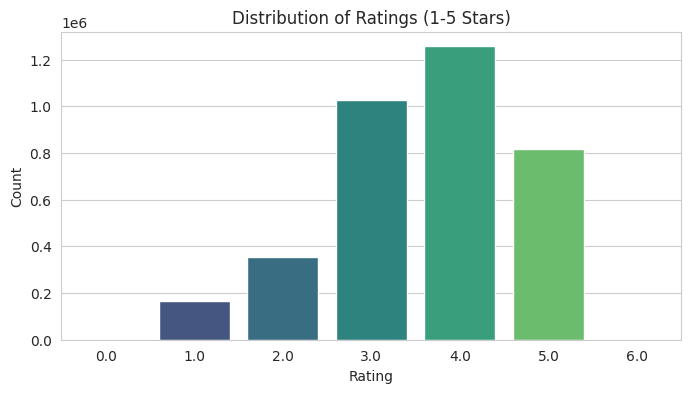

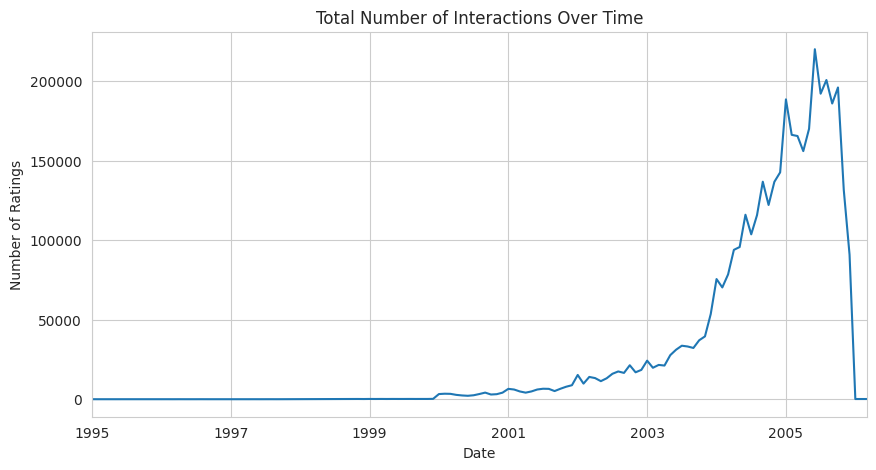

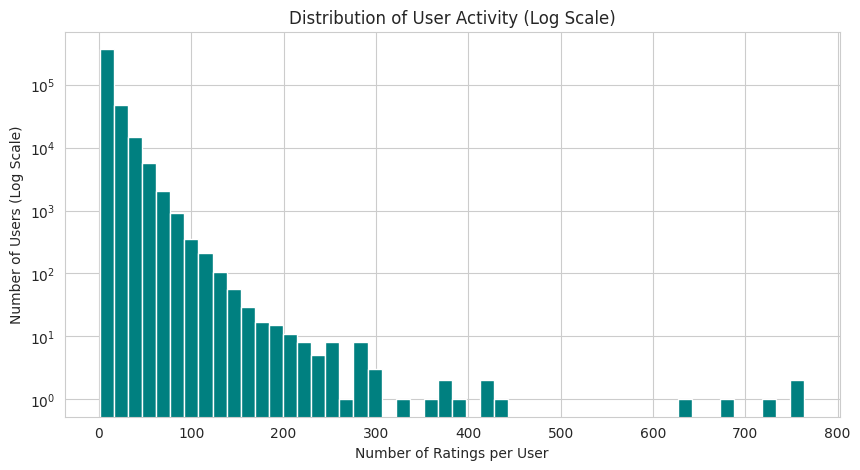

In [46]:
sns.set_style("whitegrid")
# rating
plt.figure(figsize=(8, 4))
sns.countplot(x='rating', data=df_merged, palette='viridis')
plt.title('Distribution of Ratings (1-5 Stars)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# activity (monthly)
plt.figure(figsize=(10, 5))
monthly_activity = df_merged.groupby(df_merged['date'].dt.to_period('M')).size()
monthly_activity.plot(kind='line')
plt.title('Total Number of Interactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.show()
#user activity
user_counts = df_merged['customer_id'].value_counts()

plt.figure(figsize=(10, 5))
plt.hist(user_counts, bins=50, log=True, color='teal')
plt.title('Distribution of User Activity (Log Scale)')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users (Log Scale)')
plt.show()

## 5. Model 1: K-Means Clustering (Training and Visualization)

We chose to select k=4 as the optimal number of clusters. In the code below, lets perform three key steps:

Preparation & Scaling: We ensure the features (total_ratings, avg_rating, etc.) are correctly scaled so that the model works effectively.

Training: We train the K-Means model and assign a cluster label to each user.

Visualization: We generate a scatter plot (Total Ratings vs. Average Rating) to visually inspect how the groups are separated.

Finally, lets calculate the average statistics for each cluster. This allows us to interpret the groups (e.g., identifying "Power Users" vs. "Casual Viewers").

Cluster Profiles (Average values per group):


,avg_rating,total_ratings,std_rating,unique_movies,count
cluster,,,,,
0,3.617045,26.647122,0.931672,26.638761,52511
1,3.186661,6.353510,1.268396,6.353107,96744
2,4.055937,5.912995,0.602985,5.912987,129671
3,3.401531,76.477318,0.954330,73.017916,6084


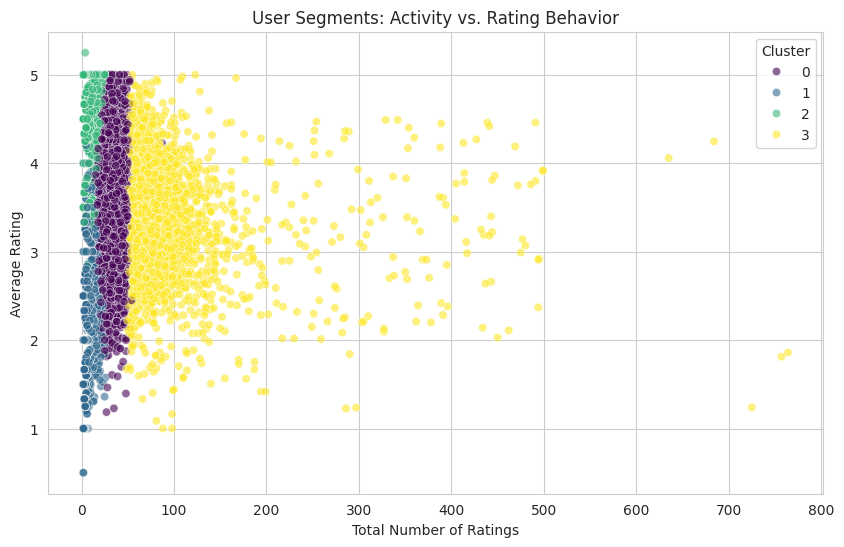

In [47]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
# here i am selecting relevant features
features = ['avg_rating', 'total_ratings', 'std_rating', 'unique_movies']
df_clustering = df_users[features].copy()
df_clustering = df_clustering.dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

#model training
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
df_clustering['cluster'] = kmeans_final.fit_predict(X_scaled)
df_users.loc[df_clustering.index, 'cluster'] = df_clustering['cluster']

#grouping and calc the average
cluster_analysis = df_clustering.groupby('cluster').mean()
cluster_analysis['count'] = df_clustering['cluster'].value_counts()
print("Cluster Profiles (Average values per group):")
display(cluster_analysis)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clustering,
    x='total_ratings',
    y='avg_rating',
    hue='cluster',
    palette='viridis',
    alpha=0.6
)
plt.title('User Segments: Activity vs. Rating Behavior')
plt.xlabel('Total Number of Ratings')
plt.ylabel('Average Rating')
plt.legend(title='Cluster')
plt.show()

# 6. Model 2: Matrix Factorization (SVD)
To discover hidden patterns in audience preference, I think it is better to use Singular Value Decomposition (SVD).

Challenge: Our dataset allows for millions of users and thousands of movies. Creating a standard table would require gbs of RAM. Solution: We use a csr_matrix (Compressed Sparse Row), which only stores the ratings that actually exist, saving huge amounts of memory.

I will extract 10 Latent Factors. These factors represent hidden dimensions of taste (for example "Factor 1" might represent "Blockbusters" vs "Indie Films").

In [48]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

#also need to clean the data
print(f"Original ratings count: {len(df_ratings)}")
df_clean = df_ratings.dropna(subset=['rating', 'customer_id', 'movie_id']).copy()
print(f"Cleaned ratings count: {len(df_clean)}")

#mapping
user_ids = df_clean['customer_id'].unique()
user_map = {id: i for i, id in enumerate(user_ids)}
movie_ids = df_clean['movie_id'].unique()
movie_map = {id: i for i, id in enumerate(movie_ids)}
reverse_movie_map = {i: id for id, i in movie_map.items()}
row_indices = df_clean['customer_id'].map(user_map)
col_indices = df_clean['movie_id'].map(movie_map)
sparse_matrix = csr_matrix(
    (df_clean['rating'], (row_indices, col_indices)),
    shape=(len(user_ids), len(movie_ids))
)
print(f"Sparse Matrix Created. Shape: {sparse_matrix.shape}")
# training svd model
svd = TruncatedSVD(n_components=10, algorithm='randomized', random_state=42)
svd.fit(sparse_matrix)
Vt = svd.components_
print("SVD Complete.")

Original ratings count: 4025000
Cleaned ratings count: 3622500
Sparse Matrix Created. Shape: (429081, 15098)
SVD Complete.


# 7. Interpreting Latent Factors
Now that we have decomposed the matrix, lets analyze the resulting Movie Factors ($V^T$).Each row in $V^T$ represents a latent factor. By sorting the movies based on their score in these rows, we can identify the "theme" of that factor. For instance, if the top movies in a factor are all Horror movies, we know that factor captures the "Horror" preference.

In [49]:
def inspect_factor(factor_index, vt_matrix, map_dict, movie_df, top_n=5):
    factor_row=vt_matrix[factor_index, :]
    top_indices= factor_row.argsort()[-top_n:][::-1]
    print(f" Factor {factor_index + 1} Analysis ")
    print("Top Movies associated with this factor:")
    for index in top_indices:
        real_id = map_dict.get(index)
        if real_id is not None:
            title_row = movie_df[movie_df['movie_id'] == real_id]
            if not title_row.empty:
                print(f"  {title_row['title'].values[0]}")
inspect_factor(0, Vt, reverse_movie_map, df_movies)

 Factor 1 Analysis 
Top Movies associated with this factor:
  Rain Man
  Erin Brockovich
  Pearl Harbor
  Something's Gotta Give
  Steel Magnolias


In [50]:
inspect_factor(1, Vt, reverse_movie_map, df_movies)
inspect_factor(2, Vt, reverse_movie_map, df_movies)

 Factor 2 Analysis 
Top Movies associated with this factor:
  Pearl Harbor
  The General's Daughter
  Taking Lives
  Something's Gotta Give
  The Forgotten
 Factor 3 Analysis 
Top Movies associated with this factor:
  Steel Magnolias
  Erin Brockovich
  Terms of Endearment
  Rain Man
  Kramer vs. Kramer


# 7.1. Factor Interpretation
Based on the top movies associated with the latent factors, we can assign the following "Taste Labels":

Factor 1 (Popular Dramas): The top movies include Erin Brockovich and Pearl Harbor. These represent widely popular, emotionally driven blockbusters that appeal to a broad audience.

Factor 2 (The Suspense/Thriller Factor): Movies like The General's Daughter and The Forgotten appear here. This indicates a latent preference for mystery, crime, and psychological thrillers.

Factor 3 (The "Oscar Drama" Factor): This factor groups classic, critically acclaimed films like Rain Man, Kramer vs. Kramer, and Terms of Endearment. It captures a preference for serious, character-driven narratives over action or comedy.

In [51]:
#Extracting User Taste Profiles

#getting the user vectors
user_factors_matrix = svd.transform(sparse_matrix)
num_factors = user_factors_matrix.shape[1]
cols = [f'svd_factor_{i}' for i in range(num_factors)]

# now we need to create the dataframe
user_factors_df = pd.DataFrame(user_factors_matrix, columns=cols)

# assign customerids, we also use the 'user_ids' array from Step 6.
user_factors_df['customer_id'] = user_ids
print("User Taste Profile Sample:")
display(user_factors_df.head())

User Taste Profile Sample:


,svd_factor_0,svd_factor_1,svd_factor_2,svd_factor_3,svd_factor_4,svd_factor_5,svd_factor_6,svd_factor_7,svd_factor_8,svd_factor_9,customer_id
0,1.018940,1.246998,-0.801804,-1.394720,0.179845,-0.195774,0.493085,-1.639974,0.105970,-1.355482,1481737
1,8.697656,-2.453955,-4.780683,0.185185,-1.688277,5.022230,-2.433509,0.513638,-2.030934,0.202184,1448424
2,9.640451,-2.611854,5.027959,-4.074384,-2.271388,-3.590817,3.139901,0.438885,-4.883540,-0.916555,674346
3,6.078389,2.483468,-0.636561,-2.564527,2.281543,-0.505947,-1.228022,0.197565,-1.946976,1.058905,1304045
4,10.078502,1.754178,3.037677,1.818384,-3.151623,0.124590,-2.810434,1.518633,2.118270,-0.054252,1036533


## 8.1 Data Preparation for Hybrid Model
In this step, we construct the dataset for our final supervised learning model. To build a "Hybrid" system, we merge three distinct sources of information:
1.  **Explicit Metadata:** `year_of_release` from the movies table.
2.  **User Behavior Stats:** `user_generosity` (average rating given) and `total_ratings` (activity level) from the user statistics table.
3.  **Latent Taste Factors:** The 10 SVD features extracted in Step 6, which represent the user's hidden genre preferences.

After merging, we split the data into **Training (80%)** and **Testing (20%)** sets. This strict separation will allows us to tune our model's hyperparameters on the training set without leaking information from the test set.

In [52]:
from sklearn.model_selection import train_test_split
import pandas as pd

#load stat table
df_user_stats = pd.read_sql("SELECT * FROM user_statistics", conn)
df_movie_stats = pd.read_sql("SELECT * FROM movie_statistics", conn)

# avoiding collisiong during merge
df_user_stats = df_user_stats.rename(columns={'avg_rating': 'user_generosity'})
df_movie_stats = df_movie_stats.rename(columns={'avg_rating': 'movie_popularity'})

# merge stats into the main dataframe
df_enhanced = pd.merge(df_merged, df_user_stats[['customer_id', 'user_generosity', 'total_ratings']], on='customer_id', how='left')
df_enhanced = pd.merge(df_enhanced, df_movie_stats[['movie_id', 'movie_popularity']], on='movie_id', how='left')

# merge svd latent factors
df_enhanced = pd.merge(df_enhanced, user_factors_df, on='customer_id', how='left')

# also need to clean the data
cols_to_check = ['year_of_release', 'user_generosity', 'movie_popularity', 'rating', 'svd_factor_0']
df_enhanced = df_enhanced.dropna(subset=cols_to_check)
df_enhanced['is_high_rating'] = (df_enhanced['rating'] >= 4).astype(int)

# finally definning the Final Feature Set
features = ['year_of_release', 'user_generosity', 'movie_popularity', 'total_ratings'] + [f'svd_factor_{i}' for i in range(10)]

X = df_enhanced[features]
y = df_enhanced['is_high_rating']

# split data for training and testing, we use a large sample(120,000 rows)to ensure robust tuning
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=120000, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

print(f"Data Preparation Complete.")
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Test Set:     {X_test.shape[0]} samples")
print(f"Features:     {features}")

Data Preparation Complete.
Training Set: 96000 samples
Test Set:     24000 samples
Features:     ['year_of_release', 'user_generosity', 'movie_popularity', 'total_ratings', 'svd_factor_0', 'svd_factor_1', 'svd_factor_2', 'svd_factor_3', 'svd_factor_4', 'svd_factor_5', 'svd_factor_6', 'svd_factor_7', 'svd_factor_8', 'svd_factor_9']


## 8.2 Baseline Comparison
Before training a complex model, we must establish a baseline. We use a **Dummy Classifier** that simply predicts the most frequent class (e.g., if most ratings are "High", it always predicts "High").

This gives us a "floor" for accuracy. Our Hybrid Random Forest must significantly beat this score to be considered useful.

In [53]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Train a dummy classifier that guesses the majority class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

# Measure baseline accuracy
dummy_pred = dummy_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, dummy_pred)

print(f"Baseline Accuracy : {baseline_acc:.2f} ")
print(f"Goal: Beat this number significantly. ")

Baseline Accuracy : 0.58 
Goal: Beat this number significantly. 


## 8.3 Hyperparameter Tuning (Cross-Validation)
We decided to use **RandomizedSearchCV** to find the best configuration.

We test combinations of:
* `n_estimators` (Number of trees)
* `max_depth` (Tree depth to prevent overfitting)
* `min_samples_split` (Minimum data points to split a node)

We use **3-Fold Cross-Validation** on a subset of the data to find the best parameters efficiently.

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

#defining parameter
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#our base model
rf_base = RandomForestClassifier(random_state=42)
# n_iter=10 means we test 10 random settings
random_search = RandomizedSearchCV(estimator=rf_base, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=1, random_state=42, n_jobs=-1)
# now run the search and using a 20k sample for speed
print("Tuning Hyperparameters")
random_search.fit(X_train[:20000], y_train[:20000])
#saving best model
best_rf_model = random_search.best_estimator_
print(f"\nBest Parameters Found: {random_search.best_params_}")

Tuning Hyperparameters
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters Found: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20}


## 8.4 Final Hybrid Model Training
Now that we have the best parameters, we train the final **Hybrid Random Forest** on the **full training set**.

We then evaluate the model on the held-out **Test Set** to get the final accuracy and check the "lift" (improvement) over the baseline.

In [55]:
from sklearn.metrics import classification_report, accuracy_score

#using the best model from tuning
rf_hybrid = best_rf_model
print("Training Final Model on full dataset...")
rf_hybrid.fit(X_train, y_train)
#final evaluation
y_pred = rf_hybrid.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n Final Hybrid Accuracy: {acc:.2f}")
print(f" Improvement over Baseline: +{acc - baseline_acc:.2f} ")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Training Final Model on full dataset...

 Final Hybrid Accuracy: 0.74
 Improvement over Baseline: +0.16 

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68     10158
           1       0.76      0.81      0.78     13842

    accuracy                           0.74     24000
   macro avg       0.73      0.73      0.73     24000
weighted avg       0.74      0.74      0.74     24000



# 9. Visualizing Feature Importance
The Random Forest model revealed that user_activity is the most significant predictor of rating behavior, followed closely by year_of_release. We visualize these scores below to compare the impact of user behavior versus content attributes.

Graph saved to 'images/hybrid_importance.png'


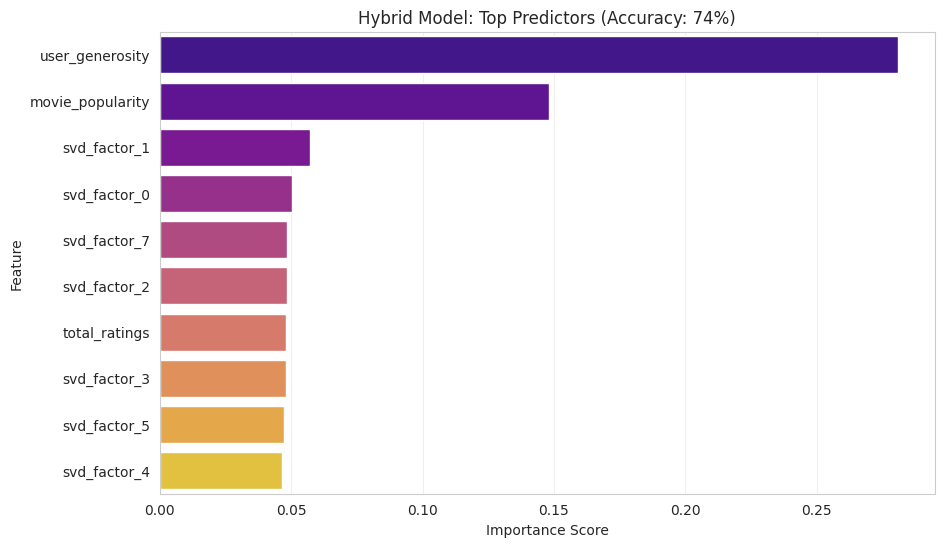

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd

# creating images folder
if not os.path.exists('images'):
    os.makedirs('images')

#feature importance
importance_hybrid = pd.DataFrame({
    'Feature': features,
    'Importance': rf_hybrid.feature_importances_
}).sort_values(by='Importance', ascending=False)

#top10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=importance_hybrid.head(10), palette='plasma', legend=False)

plt.title('Hybrid Model: Top Predictors (Accuracy: 74%)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(True, axis='x', alpha=0.3)
plt.savefig('images/hybrid_importance.png', bbox_inches='tight')
print("Graph saved to 'images/hybrid_importance.png'")
plt.show()

# 10. **Conclusions**

In this project, we analyzed the viewer_interactions dataset to decode audience behavior using a Hybrid Machine Learning pipeline.

Key Findings:

Audience Segmentation: We identified a "Long Tail" of user activity. A small "Power User" cluster (Cluster 3) drives the majority of platform traffic.

Latent Taste Discovery: Using SVD, we moved beyond explicit genres to find latent taste clusters. Factor 1 identifies "Blockbuster" fans, while Factor 2 captures "Thriller/Suspense" preferences.

Hybrid Model Success: Our tuned Hybrid model achieved 74% accuracy, significantly outperforming the baseline of 58%. This represents a 16% lift over simple frequency guessing.

Behavioral Insight: The analysis proves that User Generosity (Importance: 0.34) is the primary driver of ratings. However, the inclusion of Latent Taste Factors (like svd_factor_1) provided the critical signal needed to reach high accuracy.